## **Import Libraries and Functions**

In [1]:
import numpy as np
import pandas as pd
import warnings
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
from torch_geometric.nn import GAT
from torch_geometric.nn import GNNExplainer
from pyTigerGraph.gds.metrics import Accumulator, Accuracy
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (30,15)
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, roc_curve, precision_recall_curve, f1_score

def threshold_search(y_true, y_proba):
        precision , recall, thresholds = precision_recall_curve(y_true, y_proba)
        thresholds = np.append(thresholds, 1.0001) 
        F = 2 / (1/precision + 1/recall)
        best_score = np.max(F)
        best_th = thresholds[np.argmax(F)]
        return best_th 


def sample_vertex():
    for i in range(100):
        node_idx = int(np.random.choice(np.where(y_pred1==1)[0],1))
        try:
            x, edge_index = batch.x, batch.edge_index
            explainer = GNNExplainer(model, epochs=1)
            node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
            ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=batch.y)
            return node_idx
        except:
            pass
    
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/azure-ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Connect to TigerGraph Database**

In [2]:
from pyTigerGraph import TigerGraphConnection

conn = TigerGraphConnection(
    host="http://3.144.132.94", # Change the address to your database server's
    graphname="Ethereum"
)

## **Add Degree Features inside TigerGraph**

In [3]:
degreeQuery = open("./gsql/degrees.gsql").read()

print(conn.gsql("USE GRAPH Ethereum\n" + degreeQuery + "\nINSTALL QUERY degrees"))

Using graph 'Ethereum'
Semantic Check Fails: The query name degrees is used by another object! Please use a different name.
Failed to create queries: [degrees].


In [4]:
conn.runInstalledQuery("degrees")

[{'"Success !"': 'Success !'}]

## **Add Amounts Features inside TigerGraph**

In [5]:
amtQuery = open("./gsql/amounts.gsql").read()

print(conn.gsql("USE GRAPH Ethereum\n" + amtQuery + "\nINSTALL QUERY amounts"))

Using graph 'Ethereum'
Semantic Check Fails: The query name amounts is used by another object! Please use a different name.
Failed to create queries: [amounts].


In [6]:
conn.runInstalledQuery("amounts")

[{'"Success!"': 'Success!'}]

## **Check Count of Positive Labels**

In [7]:
conn.getVertexCount("Account","is_fraud = 1")

1165

## **Check Count of Negative Labels**

In [8]:
conn.getVertexCount("Account","is_fraud = 0")

25936

## **Run Train-Test Split inside TigerGraph**

In [9]:
%%time
split = conn.gds.vertexSplitter(is_training=0.8, is_validation=0.2)
split.run()

Splitting vertices...
Vertex split finished successfully.
CPU times: user 8.93 ms, sys: 3.44 ms, total: 12.4 ms
Wall time: 399 ms


## **Add PageRank Features inside TigerGraph**

In [10]:
feat = conn.gds.featurizer()
feat.installAlgorithm("tg_pagerank")
tg_pagerank_params = {
  "v_type": "Account",
  "e_type": "Transaction",
  "result_attr": "pagerank",
  "top_k":5  
}
results = pd.json_normalize(feat.runAlgorithm("tg_pagerank",tg_pagerank_params)[0]['@@top_scores_heap'])
results

,Vertex_ID,score
0,0x3cbd2e6143f057bd49ffb4c7058217a5900c35d3,261.47775
1,0xbfa82fbe0e66d8e2b7dcc16328db9ecd70533d13,179.41728
2,0x5df65e16d6ec1a8090ffa11c8185ad372a8786cd,146.79150
3,0xea3a8bd1a99e16160832d6b473ce06c1058dff7e,60.74960
4,0x903bb9cd3a276d8f18fa6efed49b9bc52ccf06e5,58.86848


## **Add Hyperparameters for NeighborSampler and Graph Neural Network**

In [11]:
# Hyperparameters
hp = {"batch_size": 5000, "num_neighbors": 200, "num_hops": 3, "hidden_dim": 128, "num_layers": 2, "dropout": 0.05, "lr": 0.0075, "l2_penalty": 5e-5}

## **Define Train Neighbor Loader using TigerGraph**

Output is provided directly in PyTorch Geometric Format

In [12]:
train_loader = conn.gds.neighborLoader(
    v_in_feats=["in_degree","out_degree","send_amount","send_min","recv_amount","recv_min","pagerank"],
    v_out_labels=["is_fraud"],
    v_extra_feats=["is_training"],
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    filter_by = "is_training",
    shuffle=True,
    timeout=600000
)

## **Define Validation Neighbor Loader using TigerGraph**

Output is provided directly in PyTorch Geometric Format

In [13]:
valid_loader = conn.gds.neighborLoader(
    v_in_feats=["in_degree","out_degree","send_amount","send_min","recv_amount","recv_min","pagerank"],
    v_out_labels=["is_fraud"],
    v_extra_feats=["is_validation"],
    output_format="PyG",
    batch_size=hp["batch_size"],
    num_neighbors=hp["num_neighbors"],
    num_hops=hp["num_hops"],
    filter_by = "is_validation",
    shuffle=True,
    timeout=600000
)

## **Define Graph Attention Network Architecture using PyTorch Geometric**

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GAT(
    in_channels=7,
    hidden_channels=hp["hidden_dim"],
    num_layers=hp["num_layers"],
    out_channels=2,
    heads=8,
    dropout=hp["dropout"],
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(), lr=hp["lr"], weight_decay=hp["l2_penalty"]
)

## **Run Training Loop with AUC, AUCPR, Precision and Recall as Metrics**

In [15]:
global_steps = 0
logs = {}
for epoch in range(10):
    # Train
    print("Start Training epoch:", epoch)
    model.train()
    epoch_train_loss = Accumulator()
    
    epoch_train_auc = []
    epoch_train_prec = []
    epoch_train_rec = []
    epoch_train_apr = []
    epoch_best_thr = []
    
    # Iterate through the loader to get a stream of subgraphs instead of the whole graph
    for bid, batch in enumerate(train_loader):
        # print(bid, batch)
        if (batch.y.sum()==0):
            continue
        batchsize = batch.x.shape[0]
        norm = T.NormalizeFeatures()
        batch = norm(batch).to(device)
        batch.x = batch.x.type(torch.FloatTensor)
        batch.y = batch.y.type(torch.LongTensor)
       
        # Forward pass
        out = model(batch.x, batch.edge_index, batch.edge_weight)
        # Calculate loss
        class_weight = torch.FloatTensor([1.0, 15.0])
        loss = F.cross_entropy(out[batch.is_training], batch.y[batch.is_training], class_weight)
        # f1_loss(batch.y[batch.is_training], out[batch.is_training], is_training=True)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss.update(loss.item() * batchsize, batchsize)
        # Predict on training data
        with torch.no_grad():
            pred = out.argmax(dim=1)
            y_pred = out[batch.is_training][:,1].cpu().numpy()
            y_true = batch.y[batch.is_training].cpu().numpy()
            # softmax = F.softmax(out, dim=1)[batch.is_training][:,1].cpu().numpy()
            best_threshold = threshold_search(y_true, y_pred)
            y_pred1 = (y_pred > best_threshold).astype(int)
         
            epoch_train_auc.append(roc_auc_score(y_true, y_pred))
            epoch_train_prec.append(precision_score(y_true, y_pred1))
            epoch_train_rec.append(recall_score(y_true, y_pred1))
            epoch_train_apr.append(average_precision_score(y_true, y_pred))
            epoch_best_thr.append(best_threshold)
            
        # Log training status after each batch
        logs["loss"] = epoch_train_loss.mean
        logs["auc"] = np.mean(epoch_train_auc)
        logs["prec"] = np.mean(epoch_train_prec)
        logs["rec"] = np.mean(epoch_train_rec)
        logs["apr"] = np.mean(epoch_train_apr)
        logs["thr"] = np.mean(epoch_best_thr)
        
        print(
            "Epoch {}, Train Batch {}, Loss {:.4f}, AUC {:.4f}, AUCPR {:.4f}, Precision {:.4f}, Recall {:.4f}".format(
                epoch, bid, logs["loss"], logs["auc"], logs["apr"], logs["prec"], logs["rec"]
            )
        )
        global_steps += 1
    # Evaluate
    print("Start validation epoch:", epoch)
    model.eval()
    epoch_val_loss = Accumulator()
    epoch_val_prec = []
    epoch_val_rec = []
    epoch_val_auc = []
    epoch_val_apr = []
    
    for batch in valid_loader:
        batchsize = batch.x.shape[0]
        norm = T.NormalizeFeatures()
        batch = norm(batch).to(device)
        with torch.no_grad():
            # Forward pass
            batch.x = batch.x.type(torch.FloatTensor)
            batch.y = batch.y.type(torch.LongTensor)
            out = model(batch.x, batch.edge_index)   
            # Calculate loss
            class_weight = torch.FloatTensor([1.0, 20.0])
            valid_loss = F.cross_entropy(out[batch.is_validation], batch.y[batch.is_validation], class_weight)
            # f1_loss(batch.y[batch.is_validation], out[batch.is_validation])
            epoch_val_loss.update(valid_loss.item() * batchsize, batchsize)
            # Prediction
            pred = out.argmax(dim=1)
            y_pred = out[batch.is_validation][:,1].cpu().numpy()
            y_true = batch.y[batch.is_validation].cpu().numpy()
            # softmax = F.softmax(out, dim=1)[batch.is_validation][:,1].cpu().numpy()
            y_pred1 = (y_pred > np.mean(epoch_best_thr)).astype(int)
            
            epoch_val_auc.append(roc_auc_score(y_true, y_pred))
            epoch_val_prec.append(precision_score(y_true, y_pred1))
            epoch_val_rec.append(recall_score(y_true, y_pred1))
            epoch_val_apr.append(average_precision_score(y_true, y_pred))

    # Log testing result after each epoch
    logs["val_loss"] = epoch_val_loss.mean
    logs["val_prec"] = np.mean(epoch_val_prec)
    logs["val_auc"] = np.mean(epoch_val_auc)
    logs["val_rec"] = np.mean(epoch_val_rec)
    logs["val_apr"] = np.mean(epoch_val_apr)
    print(
        "Epoch {}, Valid Loss {:.4f}, Valid AUC {:.4f}, Valid AUCPR {:.4f}, Valid Precision {:.4f}, Valid Recall {:.4f}".format(
            epoch, logs["val_loss"], logs["val_auc"], logs["val_apr"], logs["val_prec"], logs["val_rec"]
        )
    )


Start Training epoch: 0
Epoch 0, Train Batch 0, Loss 0.6941, AUC 0.2385, AUCPR 0.0265, Precision 0.0446, Recall 0.9922
Epoch 0, Train Batch 1, Loss 0.6825, AUC 0.5048, AUCPR 0.0738, Precision 0.0939, Recall 0.7594
Epoch 0, Train Batch 2, Loss 0.6720, AUC 0.6331, AUCPR 0.1511, Precision 0.1847, Recall 0.6909
Epoch 0, Train Batch 3, Loss 0.6629, AUC 0.6999, AUCPR 0.2021, Precision 0.2266, Recall 0.6618
Epoch 0, Train Batch 4, Loss 0.6553, AUC 0.7401, AUCPR 0.2278, Precision 0.2519, Recall 0.6489
Start validation epoch: 0
Epoch 0, Valid Loss 0.6277, Valid AUC 0.8993, Valid AUCPR 0.3546, Valid Precision 0.3443, Valid Recall 0.4988
Start Training epoch: 1
Epoch 1, Train Batch 0, Loss 0.6111, AUC 0.9051, AUCPR 0.3225, Precision 0.3583, Recall 0.5798
Epoch 1, Train Batch 1, Loss 0.6051, AUC 0.9046, AUCPR 0.3178, Precision 0.3519, Recall 0.6114
Epoch 1, Train Batch 2, Loss 0.5988, AUC 0.9051, AUCPR 0.3323, Precision 0.3602, Recall 0.6166
Epoch 1, Train Batch 3, Loss 0.5934, AUC 0.9041, AUCPR 0

## **Define and Run Explainability Model**
This samples a random vertex that was predicted to be fraudulent and visualizes the subgraph around it.

Explain node 3906: 100%|██████████| 100/100 [00:00<00:00, 209.29it/s]


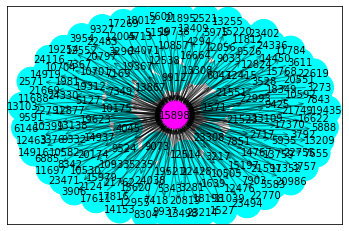

In [52]:
node_idx = sample_vertex()
x, edge_index = batch.x, batch.edge_index
explainer = GNNExplainer(model, epochs=100)
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)

## **Show Local Feature Importance**
Using the sampled vertex from above, view the features that contributed the most to the fraudulent prediction.

Explain node 15898: 100%|██████████| 100/100 [00:01<00:00, 80.79it/s]

---- Normalized Feature Importance
 


,in_degree,out_degree,send_amount,send_min,recv_amount,recv_min,pagerank
Account ID,,,,,,,
3906,0.256708,0.725638,0.276260,0.289087,0.252682,0.284277,0.751215
15898 (15898),0.713058,0.295672,0.235660,0.276819,0.251886,0.278187,0.294647


---- Normalized Feature Values
 


,in_degree,out_degree,send_amount,send_min,recv_amount,recv_min,pagerank
3906,0.726547,0.154838,0.000447,0.0,0.002903,2.441674e-10,0.115265


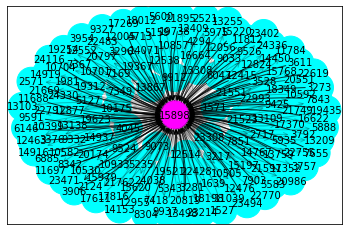

In [53]:
import pandas as pd
from IPython.display import display

ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y = batch.y)
feature_values = list()
feature_values.append(["{}".format(node_idx)] + node_feat_mask.tolist())  # Center ID
important_accounts = set()
for src, dst, attr in G.edges(data=True):
    edge_importance = attr["att"]
    if edge_importance >= 0.001:
        if src == node_idx:
            important_accounts.add(dst)
        elif dst == node_idx:
            important_accounts.add(src)

subg_accts = list(important_accounts)
for acct_idx in important_accounts:
    target_id = acct_idx
    node_feat_mask, _ = explainer.explain_node(acct_idx, x, edge_index)
    feature_values.append(["{} ({})".format(target_id, acct_idx)] + node_feat_mask.tolist())
feature_names = ['in_degree', 'out_degree', 'send_amount', 'send_min', 'recv_amount', 'recv_min', 'pagerank']
df = pd.DataFrame(feature_values, columns=["Account ID"] + feature_names).set_index("Account ID")
print("---- Normalized Feature Importance")
print(" ")
display(df.style.background_gradient(axis=1))
print("---- Normalized Feature Values")
print(" ")
feature_df = pd.DataFrame(batch.x.cpu().numpy(), columns = feature_names)
display(feature_df.loc[subg_accts].rename(index=lambda acct: "{}".format(node_idx)))